## Assignment - 2 (Model Creation)

### Data Exploration

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools
import plotly.express as px
import plotly.graph_objects as go
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import plotly.offline as py



In [2]:
#Reading the convections files with outcome and merging them
path = r'/content' #For Google Colab
#path =  str(pathlib.Path('Assignment2.ipynb').parent.absolute()) #For windows

all_files = glob.glob(path + "/*.csv")
csv_list = []
for file in all_files:
    df = pd.read_csv(file, index_col=None, header=0)
    csv_list.append(df)
raw_stop_search = pd.concat(csv_list, axis=0, ignore_index=True)

In [3]:
#showing the first 3 rows of the dataset
raw_stop_search.head(3)

,Type,Date,Part of a policing operation,Policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing
0,Person search,2020-05-31T23:00:00+00:00,False,NaN,51.544736,-0.147623,Male,10-17,Other ethnic group - Not stated,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,NaN
1,Person search,2020-05-31T23:00:00+00:00,False,NaN,51.540824,0.055394,Male,NaN,Other ethnic group - Not stated,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,NaN
2,Person search,2020-05-31T23:00:00+00:00,False,NaN,51.540824,0.055394,Male,NaN,Other ethnic group - Not stated,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,NaN


**Initial Information**

In [4]:
raw_stop_search.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329350 entries, 0 to 329349
Data columns (total 15 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Type                                      329350 non-null  object 
 1   Date                                      329350 non-null  object 
 2   Part of a policing operation              329350 non-null  bool   
 3   Policing operation                        0 non-null       float64
 4   Latitude                                  293997 non-null  float64
 5   Longitude                                 293997 non-null  float64
 6   Gender                                    324532 non-null  object 
 7   Age range                                 290203 non-null  object 
 8   Self-defined ethnicity                    324566 non-null  object 
 9   Officer-defined ethnicity                 321855 non-null  object 
 10  Legislation         

**Columns containing less than 19 unique values**

In [5]:
# Showing columns with less than 7 distinct values
non_unique = raw_stop_search.apply(pd.Series.nunique)
static_columns = non_unique[(non_unique>=1)&(non_unique<19)].index
static_columns

Index(['Type', 'Part of a policing operation', 'Gender', 'Age range',
       'Self-defined ethnicity', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'Outcome'],
      dtype='object')

**Unique values in columns containing less than 19 unique values**

In [6]:
 # Showing the distinct values in columns that contain less than 7 distinct values
for i in static_columns:
    print('column:',i,'\nNumber of unique values:',len(raw_stop_search[i].unique()),'\nUnique values:',raw_stop_search[i].unique(),'\n')

column: Type 
Number of unique values: 3 
Unique values: ['Person search' 'Person and Vehicle search' 'Vehicle search'] 

column: Part of a policing operation 
Number of unique values: 1 
Unique values: [False] 

column: Gender 
Number of unique values: 4 
Unique values: ['Male' 'Female' nan 'Other'] 

column: Age range 
Number of unique values: 6 
Unique values: ['10-17' nan 'over 34' '25-34' '18-24' 'under 10'] 

column: Self-defined ethnicity 
Number of unique values: 18 
Unique values: ['Other ethnic group - Not stated'
 'Black/African/Caribbean/Black British - Any other Black/African/Caribbean background'
 'White - English/Welsh/Scottish/Northern Irish/British'
 'White - Any other White background'
 'Asian/Asian British - Any other Asian background' nan
 'Asian/Asian British - Pakistani'
 'Black/African/Caribbean/Black British - African'
 'Other ethnic group - Any other ethnic group'
 'Asian/Asian British - Indian'
 'Black/African/Caribbean/Black British - Caribbean'
 'Asian/Asian

### Features Engineering

#### Dropping Static Columns & Missing Values


In [7]:
#Showing how many missing values residing in each column
df = pd.DataFrame( raw_stop_search.isna().sum())
df

,0
Type,0
Date,0
Part of a policing operation,0
Policing operation,329350
Latitude,35353
Longitude,35353
Gender,4818
Age range,39147
Self-defined ethnicity,4784
Officer-defined ethnicity,7495


**Removing static columns and Ambiguous columns**

In [8]:
#Dropping static columns which contain the same value for all of it rows
#Ambighous columns that contains a large number of missing values have been also removed
raw_stop_search = raw_stop_search.replace('nan',np.nan)
raw_stop_search= raw_stop_search.drop(['Removal of more than just outer clothing',
                                                 'Outcome linked to object of search',
                                                 'Latitude','Longitude','Policing operation','Part of a policing operation'], axis=1)


**Removing rows with missing Gender or Self-defined ethnicity information**

In [9]:
#Missing Gender values will be removed as asumming gender is a crime in 2021 :D
raw_stop_search = raw_stop_search[pd.notnull(raw_stop_search['Gender'])]
# Missing self deffined ethnicity rows will be removed as its smaller than the officer defined athnicity and has more categories
raw_stop_search = raw_stop_search[pd.notnull(raw_stop_search['Self-defined ethnicity'])]
df = pd.DataFrame( raw_stop_search.isna().sum())
df

,0
Type,0
Date,0
Gender,0
Age range,34441
Self-defined ethnicity,0
Officer-defined ethnicity,2757
Legislation,0
Object of search,693
Outcome,1


#### Aggregating Ethnicities


In [10]:
new_ethnic_groups = {'Black/African/Caribbean/Black British - African': 'Black',
                     'White - English/Welsh/Scottish/Northern Irish/British': 'White',
                     'Asian/Asian British - Any other Asian background': 'Asian',
                     'Other ethnic group - Not stated': 'Other',
                     'Black/African/Caribbean/Black British - Any other Black/African/Caribbean background': 'Black',
                     'White - Any other White background': 'White',
                     'Black/African/Caribbean/Black British - Caribbean': 'Black',
                     'Other ethnic group - Any other ethnic group': 'Other',
                     'Mixed/Multiple ethnic groups - White and Black African': 'Mixed',
                     'Asian/Asian British - Bangladeshi': 'Asian',
                     'Mixed/Multiple ethnic groups - White and Black Caribbean': 'Mixed',
                     'White - Irish': 'White',
                     'Asian/Asian British - Indian': 'Asian',
                     'Mixed/Multiple ethnic groups - White and Asian': 'Mixed',
                     'Asian/Asian British - Pakistani': 'Asian',
                     'Mixed/Multiple ethnic groups - Any other Mixed/Multiple ethnic background': 'Mixed',
                     'Asian/Asian British - Chinese': 'Asian'}
raw_stop_search = raw_stop_search.replace(
    {"Self-defined ethnicity": new_ethnic_groups})

In [11]:
raw_stop_search['Self-defined ethnicity'].unique()

array(['Other', 'Black', 'White', 'Asian', 'Mixed'], dtype=object)

In [12]:
raw_stop_search['Officer-defined ethnicity'].unique()

array(['Asian', 'Black', 'White', 'Other', nan], dtype=object)

**Note:** According to the Pie-Chart in section **1.3 Ethnicities PieChart** the Mixed ethnicities make up 2.18% which is a significant percentage as even the black comunity has a percentage of 3.33%. Therefore, the officer defined column discards such group which leads to the elimination of the entire column as the self defined ethnicity will be used as its more specific and contains a wider range of possible values.

In [13]:
#Extracting the dates from the dataset for plotting later
dates = raw_stop_search['Date']

In [14]:
# Dropping the Officer ethnicity as described in the section above 
raw_stop_search= raw_stop_search.drop(['Date', 'Officer-defined ethnicity'],axis=1)

**Removing the rows with missing 'Age range' or 'Object of search' as those two columns are the only remining with missingng values; furthermore both columns cannot be filled as the age and search objective are non-statistical features.**

In [15]:
# Since there are around 35000 rows with missing ages, their rows will be removed as filling the missing ages 
# will cause ambiguity and will undermine the project's validity.
raw_stop_search = raw_stop_search[pd.notnull(raw_stop_search['Object of search'])]
raw_stop_search = raw_stop_search[pd.notnull(raw_stop_search['Age range'])]

**Highlighting that the dataset contains no more missing values after extraction**

In [16]:
df = pd.DataFrame( raw_stop_search.isna().sum())
df

,0
Type,0
Gender,0
Age range,0
Self-defined ethnicity,0
Legislation,0
Object of search,0
Outcome,0


In [17]:
raw_stop_search.describe()

,Type,Gender,Age range,Self-defined ethnicity,Legislation,Object of search,Outcome
count,289340,289340,289340,289340,289340,289340,289340
unique,3,3,5,5,4,8,6
top,Person search,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal
freq,211163,267808,113294,97835,193672,193672,216779


In [18]:
raw_stop_search.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289340 entries, 0 to 329349
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Type                    289340 non-null  object
 1   Gender                  289340 non-null  object
 2   Age range               289340 non-null  object
 3   Self-defined ethnicity  289340 non-null  object
 4   Legislation             289340 non-null  object
 5   Object of search        289340 non-null  object
 6   Outcome                 289340 non-null  object
dtypes: object(7)
memory usage: 17.7+ MB


#### Handling Categorial Features

**After describing the extracted dataset it can be seen that all columns has the object type which can be converted to the numerical format if the unique values are mapped to unique numbers**

In [19]:
# Showing columns with less than 7 distinct values
non_unique = raw_stop_search.apply(pd.Series.nunique)
static_columns = non_unique[(non_unique>=1)&(non_unique<19)].index
static_columns

Index(['Type', 'Gender', 'Age range', 'Self-defined ethnicity', 'Legislation',
       'Object of search', 'Outcome'],
      dtype='object')

**Showing the unique values of all columns which will be later mapped to the numerical format**

In [20]:
 # Showing the distinct values in columns that contain less than 7 distinct values
for i in static_columns:
    print('column:',i,'\nNumber of unique values:',len(raw_stop_search[i].unique()),'\nUnique values:',raw_stop_search[i].unique(),'\n')

column: Type 
Number of unique values: 3 
Unique values: ['Person search' 'Person and Vehicle search' 'Vehicle search'] 

column: Gender 
Number of unique values: 3 
Unique values: ['Male' 'Female' 'Other'] 

column: Age range 
Number of unique values: 5 
Unique values: ['10-17' 'over 34' '25-34' '18-24' 'under 10'] 

column: Self-defined ethnicity 
Number of unique values: 5 
Unique values: ['Other' 'Black' 'White' 'Asian' 'Mixed'] 

column: Legislation 
Number of unique values: 4 
Unique values: ['Misuse of Drugs Act 1971 (section 23)'
 'Police and Criminal Evidence Act 1984 (section 1)'
 'Criminal Justice and Public Order Act 1994 (section 60)'
 'Firearms Act 1968 (section 47)'] 

column: Object of search 
Number of unique values: 8 
Unique values: ['Controlled drugs' 'Offensive weapons'
 'Evidence of offences under the Act' 'Stolen goods'
 'Anything to threaten or harm anyone' 'Firearms'
 'Articles for use in criminal damage' 'Fireworks'] 

column: Outcome 
Number of unique values:

In [21]:
raw_stop_search.head(5)

,Type,Gender,Age range,Self-defined ethnicity,Legislation,Object of search,Outcome
0,Person search,Male,10-17,Other,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal
3,Person search,Male,over 34,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,A no further action disposal
4,Person search,Male,25-34,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,A no further action disposal
5,Person and Vehicle search,Male,18-24,White,Police and Criminal Evidence Act 1984 (section 1),Evidence of offences under the Act,Community resolution
6,Person search,Male,over 34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution


##### One Hot Encoding to Convert to Numerical

**As Sklearn random forest trees are not capable of handling categorial objects; the columns had to trasformed using One Hot Encoding so it can be used with the random forest model.**

In [22]:
#Creating dummies from the categorial columns
raw_stop_search_W_dummies = pd.get_dummies(raw_stop_search,columns=['Type','Gender','Age range','Self-defined ethnicity','Object of search', 'Legislation'])

**Plotting the correlation between different attributes where it can be seen columns refering to a Legislation and a set of different crimes are highly correlated giving an indication which crimes falls under which acts.**

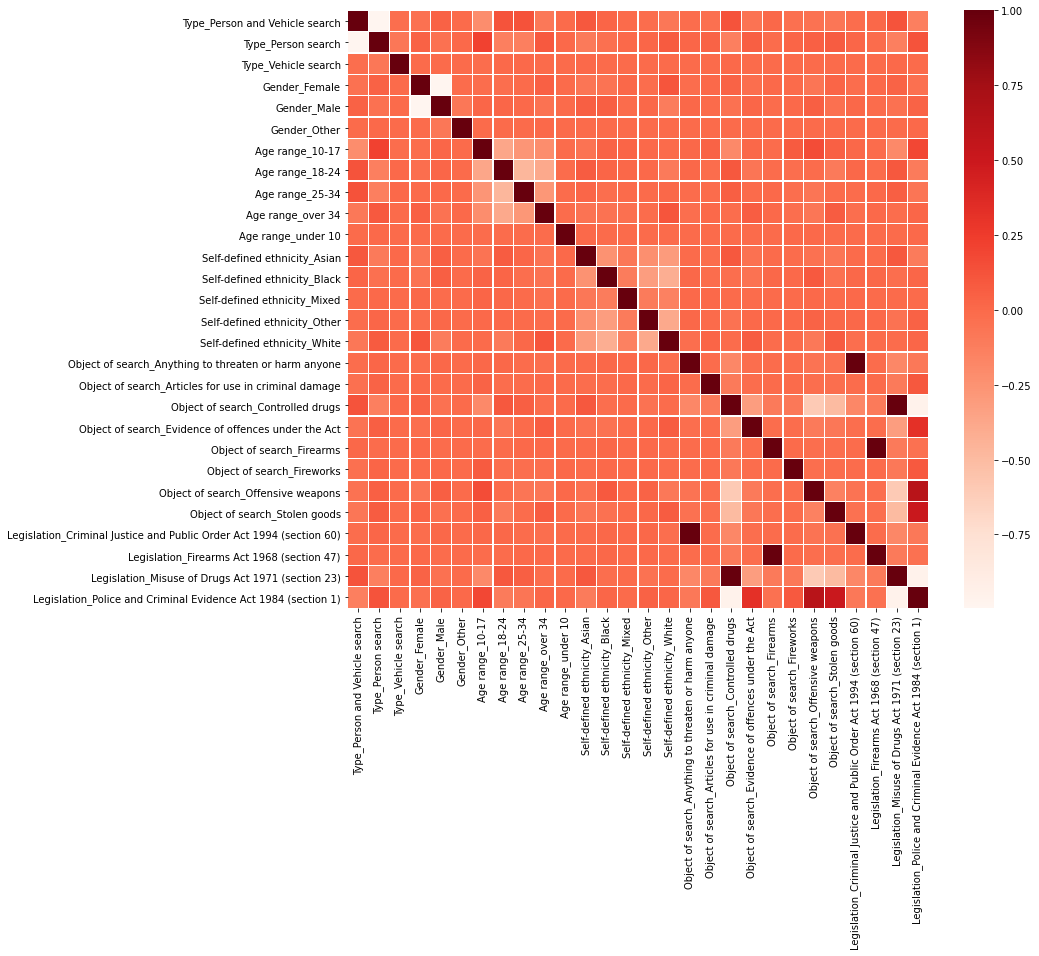

In [23]:

import seaborn as sns
import matplotlib.pyplot as plt  
f, ax = plt.subplots(figsize =(13, 11)) 
correlation = raw_stop_search_W_dummies.corr()

sns.heatmap(correlation, ax = ax, cmap = plt.cm.Reds,linewidths = 0.2) 

##### Features' Correlations

In [24]:
#Showing the features correlations (the ones between .35 and .75)
corr = correlation.abs()
to_show = corr.unstack()
sorted = to_show.sort_values(kind="quicksort",ascending = False)
sorted[(sorted>=.35)& (sorted<=.85)]

Legislation_Police and Criminal Evidence Act 1984 (section 1)  Object of search_Offensive weapons                               0.625069
Object of search_Offensive weapons                             Legislation_Police and Criminal Evidence Act 1984 (section 1)    0.625069
                                                               Legislation_Misuse of Drugs Act 1971 (section 23)                0.596432
Legislation_Misuse of Drugs Act 1971 (section 23)              Object of search_Offensive weapons                               0.596432
Object of search_Offensive weapons                             Object of search_Controlled drugs                                0.596432
Object of search_Controlled drugs                              Object of search_Offensive weapons                               0.596432
Legislation_Police and Criminal Evidence Act 1984 (section 1)  Object of search_Stolen goods                                    0.514239
Object of search_Stolen goods            

**Note:** It can be seen that the highly correlated features are between the Legislation and the object of search; which means that those features refer to a highly correlated attributes and by undersatnding the dataset both attributes refer to why the person have been searched and under what legislation; therefore in the second dataset this part will be extracted

In [25]:
#Showing the features correlations (the ones between .15 and .35)
corr = correlation.abs()
to_show = corr.unstack()
sorted = to_show.sort_values(kind="quicksort",ascending = False)
sorted[(sorted>=.15)& (sorted<=.35)]

Legislation_Police and Criminal Evidence Act 1984 (section 1)        Object of search_Evidence of offences under the Act                    0.329020
Object of search_Evidence of offences under the Act                  Legislation_Police and Criminal Evidence Act 1984 (section 1)          0.329020
                                                                     Legislation_Misuse of Drugs Act 1971 (section 23)                      0.313946
                                                                     Object of search_Controlled drugs                                      0.313946
Legislation_Misuse of Drugs Act 1971 (section 23)                    Object of search_Evidence of offences under the Act                    0.313946
Object of search_Controlled drugs                                    Object of search_Evidence of offences under the Act                    0.313946
Self-defined ethnicity_Black                                         Self-defined ethnicity_Other         

In [26]:
correlation

,Type_Person and Vehicle search,Type_Person search,Type_Vehicle search,Gender_Female,Gender_Male,Gender_Other,Age range_10-17,Age range_18-24,Age range_25-34,Age range_over 34,Age range_under 10,Self-defined ethnicity_Asian,Self-defined ethnicity_Black,Self-defined ethnicity_Mixed,Self-defined ethnicity_Other,Self-defined ethnicity_White,Object of search_Anything to threaten or harm anyone,Object of search_Articles for use in criminal damage,Object of search_Controlled drugs,Object of search_Evidence of offences under the Act,Object of search_Firearms,Object of search_Fireworks,Object of search_Offensive weapons,Object of search_Stolen goods,Legislation_Criminal Justice and Public Order Act 1994 (section 60),Legislation_Firearms Act 1968 (section 47),Legislation_Misuse of Drugs Act 1971 (section 23),Legislation_Police and Criminal Evidence Act 1984 (section 1)
Type_Person and Vehicle search,1.000000,-0.994559,-0.028065,-0.041962,0.042174,-0.003971,-0.216034,0.124453,0.129053,-0.091355,-0.003389,0.097774,0.032499,-0.002871,-0.021234,-0.083295,-0.019385,-0.033191,0.126206,-0.057059,0.010631,-0.032409,-0.052049,-0.074391,-0.019385,0.010631,0.126206,-0.124613
Type_Person search,-0.994559,1.000000,-0.076222,0.041972,-0.042192,0.004074,0.217007,-0.125030,-0.129389,0.091510,0.003460,-0.097776,-0.032292,0.002677,0.021140,0.083266,0.019457,0.033183,-0.126473,0.057242,-0.010753,0.032626,0.052088,0.074582,0.019457,-0.010753,-0.126473,0.124882
Type_Vehicle search,-0.028065,-0.076222,1.000000,-0.001107,0.001199,-0.001077,-0.014550,0.008544,0.006338,-0.003692,-0.000766,0.002378,-0.001196,0.001792,0.000386,-0.001733,-0.001156,-0.000722,0.005608,-0.003134,0.001425,-0.002872,-0.001637,-0.003636,-0.001156,0.001425,0.005608,-0.005594
Gender_Female,-0.041962,0.041972,-0.001107,1.000000,-0.996081,-0.006560,-0.017989,-0.023551,-0.002033,0.049490,-0.000669,-0.064228,-0.056974,0.010887,-0.017101,0.111304,-0.017503,0.003577,0.039652,-0.022633,0.008339,-0.003992,-0.060436,0.030221,-0.017503,0.008339,0.039652,-0.036770
Gender_Male,0.042174,-0.042192,0.001199,-0.996081,1.000000,-0.081911,0.018060,0.023555,0.001980,-0.049505,0.000701,0.064015,0.056948,-0.010663,0.016890,-0.111022,0.017287,-0.003432,-0.039256,0.022510,-0.008374,0.003892,0.060098,-0.030266,0.017287,-0.008374,-0.039256,0.036431
Gender_Other,-0.003971,0.004074,-0.001077,-0.006560,-0.081911,1.000000,-0.001475,-0.000941,0.000525,0.002047,-0.000384,-0.000015,-0.001860,-0.002115,0.001736,0.001023,0.001782,-0.001514,-0.002981,0.000536,0.000703,0.000976,0.001539,0.001651,0.001782,0.000703,-0.002981,0.002448
Age range_10-17,-0.216034,0.217007,-0.014550,-0.017989,0.018060,-0.001475,1.000000,-0.364809,-0.264645,-0.215810,-0.007515,-0.059581,0.038974,0.026810,0.003748,-0.005026,0.015569,0.035788,-0.185193,0.016873,-0.006853,0.087233,0.160021,0.056181,0.015569,-0.006853,-0.185193,0.185096
Age range_18-24,0.124453,-0.125030,0.008544,-0.023551,0.023555,-0.000941,-0.364809,1.000000,-0.466851,-0.380703,-0.013257,0.075369,0.033075,0.010097,0.008756,-0.098626,0.015395,-0.019885,0.100720,-0.065819,-0.006012,-0.023611,-0.007738,-0.095918,0.015395,-0.006012,0.100720,-0.105748
Age range_25-34,0.129053,-0.129389,0.006338,-0.002033,0.001980,0.000525,-0.264645,-0.466851,1.000000,-0.276175,-0.009617,0.018572,-0.025956,-0.005566,-0.002432,0.014264,-0.006910,-0.010738,0.062088,-0.004625,0.008455,-0.027526,-0.062464,-0.010587,-0.006910,0.008455,0.062088,-0.062479
Age range_over 34,-0.091355,0.091510,-0.003692,0.049490,-0.049505,0.002047,-0.215810,-0.380703,-0.276175,1.000000,-0.007843,-0.057940,-0.050383,-0.032471,-0.011976,0.113141,-0.026772,0.002339,-0.016308,0.071704,0.004801,-0.024320,-0.075928,0.078021,-0.026772,0.004801,-0.016308,0.023162


In [27]:
print(correlation["Object of search_Controlled drugs"].sort_values(ascending=False))

Object of search_Controlled drugs                                      1.000000
Legislation_Misuse of Drugs Act 1971 (section 23)                      1.000000
Type_Person and Vehicle search                                         0.126206
Age range_18-24                                                        0.100720
Self-defined ethnicity_Asian                                           0.098819
Age range_25-34                                                        0.062088
Gender_Female                                                          0.039652
Type_Vehicle search                                                    0.005608
Self-defined ethnicity_Mixed                                          -0.001005
Gender_Other                                                          -0.002981
Age range_under 10                                                    -0.003059
Self-defined ethnicity_White                                          -0.011036
Age range_over 34                       

In [28]:
#raw_stop_search_W_dummies['Citable docs per Capita'].corr(Top15['Energy Supply per Capita'])


In [29]:
instances = raw_stop_search_W_dummies.drop('Outcome',axis=1)
targets = pd.DataFrame(raw_stop_search_W_dummies['Outcome'])

In [30]:
#length of the data before splitting 
len(targets)

289340

#### Splitting the dataset to training and testing

**Furthermore, the subsets will be converted to numpy so they can be then split to a ratio of 70% training and a 30% testing**

In [31]:
# Converting both instances and targets to numpy arrays before splitting
x_stop_search = instances.to_numpy()
y_stop_search = targets.to_numpy()

In [32]:
# splitting the dataset into and training and testing with the mentioned ratios
x_train_stop_search, x_test_stop_search, y_train_stop_search, y_test_stop_search = train_test_split(x_stop_search,y_stop_search,
                                                                                                   test_size=0.3,random_state=50)

In [33]:
# numbers after training and testing which can be compared to the original number of 293483
print('Training instances Length: ',len(x_train_stop_search),'\nTesting instances Length: ',len(x_test_stop_search))
x_train_stop_search.shape

Training instances Length:  202538 
Testing instances Length:  86802


(202538, 28)

### Model Creation (First Preprocessing Approach)

#### Random Forest incorporated with GridSearch CV

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
# Importing RandomForestClassifier from sklearn library
# GridSearchCV will be used to determine the most suitable hyper-parameters for the classifier

random_forest = RandomForestClassifier()
params = {'criterion':['entropy'],'max_depth':[3],'n_estimators':[5,10,25,50,100]}
cross_val = RepeatedStratifiedKFold(n_splits=5,n_repeats=2)
gridSearch_CV = GridSearchCV(random_forest,params,cv=cross_val,return_train_score=False)
gridSearch_CV = gridSearch_CV.fit(x_train_stop_search,y_train_stop_search.ravel())
gridSearch_CV.best_params_

In [ ]:
gridSearch_CV.best_score_

In [ ]:
#{'criterion': 'entropy', 'max_depth': 8}

In [38]:

random_forest = RandomForestClassifier(criterion='entropy',max_depth=3,n_estimators=5)
random_forest.fit(x_train_stop_search,y_train_stop_search.ravel())
random_forest.score(x_test_stop_search,y_test_stop_search.ravel())


0.7508237558738606

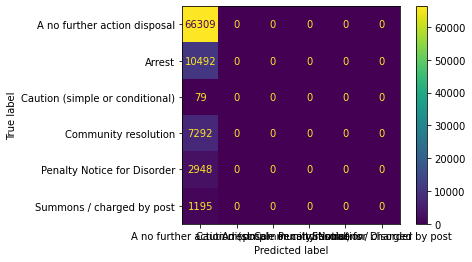

The models precision [0.75082376 0.         0.         0.         0.         0.        ] and recall [1. 0. 0. 0. 0. 0.] with a fbeta score of [0.85768057 0.         0.         0.         0.         0.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [39]:
#creating a new classifer object with the best parameters according to the earlier grid search to validate the results

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
prediction = random_forest.predict(x_test_stop_search)
plot_confusion_matrix(random_forest,x_test_stop_search,y_test_stop_search,values_format='d')
plt.show()
scores = precision_recall_fscore_support(y_test_stop_search, prediction)
print("The models precision {} and recall {} with a fbeta score of {}".format(scores[0],scores[1],scores[2]))

#### Multi-Layer Perceptron incorporated with GridSearchCV

In [ ]:
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier()
parameters = {'activation':['relu','logistic'], 'learning_rate':['constant','adaptive']} #setting the desired parameters space in a dictionary
cross_validation = RepeatedStratifiedKFold(n_splits=10,n_repeats=3)
grid_search = GridSearchCV(classifier,parameters,cv=cross_validation,return_train_score=False) #passing the model and the parameters space to GridSearchCV
grid_search = grid_search.fit(x_train_stop_search,y_train_stop_search.ravel()) # fitting the model to assess the model's performance using different combinations
grid_search.best_params_ #returns the parameters that allowed the classifier to gain its best results

In [40]:
 #Using the Standard MLP classifier to be tested with 
 from sklearn.neural_network import MLPClassifier

 classifier = MLPClassifier( learning_rate='adaptive')
 classifier.fit(x_train_stop_search, y_train_stop_search)
 classifier.score(x_test_stop_search,y_test_stop_search)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.7508124327690653

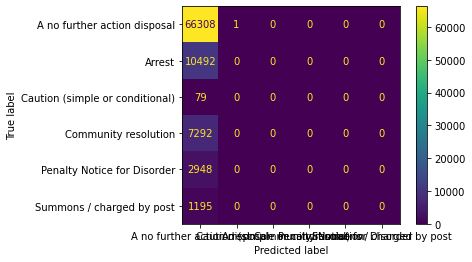

The models precision 0.6941084225633007 and recall 0.7508124327690653 with a fbeta score of 0.6439613977802003


In [41]:
prediction = classifier.predict(x_test_stop_search)
plot_confusion_matrix(classifier,x_test_stop_search,y_test_stop_search,values_format='d')
plt.show()
scores = precision_recall_fscore_support(y_test_stop_search, prediction, average = 'weighted', zero_division=1)
print("The models precision {} and recall {} with a fbeta score of {}".format(scores[0],scores[1],scores[2]))

**It can be seen that even the classifiers have a significant accuracy of 75% its classifying everything into the dominant (No further action) class which is called the accuracy paradox which can be seen in the confusion matrix**

## Using The second Preprocessing approach


**Note:** a new subset will be created so it can accommodate different features, and the subset will be then used with both the decision tree and the random forest classifier.
1. **Chnaging the classes into Binary 0=Disposal 1=Arrest**
2. **Oversampling and Undersampling the classes so they be close in quantity**
3. Changing the one-hot encoding to categorial columns
4. Removing columns that are not correlated with the target
5. Removing ambigous attributes' values such as ("")
6. **Training and testing the classifiers in addition to a Neural Network**

In [35]:
raw_stop_search.head(5)#

,Type,Gender,Age range,Self-defined ethnicity,Legislation,Object of search,Outcome
0,Person search,Male,10-17,Other,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal
3,Person search,Male,over 34,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,A no further action disposal
4,Person search,Male,25-34,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,A no further action disposal
5,Person and Vehicle search,Male,18-24,White,Police and Criminal Evidence Act 1984 (section 1),Evidence of offences under the Act,Community resolution
6,Person search,Male,over 34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution


In [36]:

# As described in the preprocessing section the Type will be removed as it had
# no correlation with any other attributes; furthermore,
# the legislation and the object of search refer to 
#the reason why the person has been stopped and under what legislation
raw_stop_search_2 = raw_stop_search.drop(columns=['Type'])
raw_stop_search_2 = raw_stop_search_2.drop(columns=['Legislation'])
raw_stop_search_2.head(3)

,Gender,Age range,Self-defined ethnicity,Object of search,Outcome
0,Male,10-17,Other,Controlled drugs,A no further action disposal
3,Male,over 34,Black,Offensive weapons,A no further action disposal
4,Male,25-34,Black,Offensive weapons,A no further action disposal


In [37]:
(raw_stop_search['Gender'] =='Other').sum()

156

In [38]:
(raw_stop_search['Age range'] =='under 10').sum()

79

In [39]:
print("The toal number of instances is {} where the total number of people with undefined gender is {} and the total number of instances where the age group was below 10 years old {}".format(len(raw_stop_search),(raw_stop_search['Gender'] =='Other').sum(),(raw_stop_search['Age range'] =='under 10').sum()))

The toal number of instances is 289340 where the total number of people with undefined gender is 156 and the total number of instances where the age group was below 10 years old 79


###Features Engineering

**Since the total number of instances belonging to the "Other" gender is only 160 instances and the age range belonging to under 10 counts only for 79 instances out of the total number of instances which is 294383**

In [40]:
#Showing the count of the following values in the objectSearch coulumn that will be alterd
print((raw_stop_search['Object of search'] == 'Evidence of offences under the Act').sum())
print((raw_stop_search['Object of search'] == 'Articles for use in criminal damage').sum())
print((raw_stop_search['Object of search'] == 'Anything to threaten or harm anyone').sum())


13433
1224
4633


In [41]:
#Removing other genders as the majority of such rows have missing values and 
# cause confusion to the classifier additionally ots only 160 instances out of 294383
cleanup = {'Gender':{'Other':np.nan}} 

#Removing instances where the stopped person is less than 10 years old
cleanup2={'Age range':{'under 10':np.nan}} 

#Regrouping both the Object of search and the outcome so they make more sense in terms of the meaning
# additionally, some ambiguous labels have been removed such as (falling under legislation labels)
cleanup3 = {'Object of search': {'Firearms':'Offensive weapons', 'Anything to threaten or harm anyone': 'Threat or Harm', 'Articles for use in criminal damage':'Breaking an act', 'Evidence of offences under the Act':'Breaking an act'}} #TODO remove 'Evidence of offences under the Act' & 'Articles for use in criminal damage'

cleanup4 = {'Outcome':{'A no further action disposal': 'Disposal', 'Summons / charged by post': 'Court Summoning','Penalty Notice for Disorder': 'Penalty/Caution', 'Caution (simple or conditional)':'Penalty/Caution' }}
raw_stop_search_2.replace(cleanup, inplace=True)
raw_stop_search_2.replace(cleanup2, inplace= True)
raw_stop_search_2.replace(cleanup3, inplace=True)
raw_stop_search_2.replace(cleanup4, inplace=True)

In [42]:
#Removing missing values from the second subset
raw_stop_search_2 = raw_stop_search_2.dropna()
raw_stop_search_2.isna().sum()


Gender                    0
Age range                 0
Self-defined ethnicity    0
Object of search          0
Outcome                   0
dtype: int64

#### Label Encoding with the Second Subset

**Converting the values from strings to numbers so they can be processed by the classifier; furthermore, the final outcome will be mapped into two classes (Binary) as 0=Disposal 1=Arrest.**

In [43]:
#Label Encoding
cleanup_gender = {'Gender':{'Male': 1, 'Female':2}}
cleanup_age = {'Age range':{'10-17':1 , '18-24':2 , '25-34':3 , 'over 34':4 }}
cleanup_ethnicity = {'Self-defined ethnicity':{'White':1, 'Asian': 2, 'Black':3, 'Mixed':4, 'Other': 5}}
cleanup_object_of_search = {'Object of search':{'Fireworks':1 ,'Stolen goods':2,'Breaking an act':3,'Threat or Harm':4,'Controlled drugs':5,'Offensive weapons':6}}
cleanup_outcome = {'Outcome':{'Disposal':0,'Further Court Action':1,'Court Summoning':1,'Community resolution':1,'Arrest':1,'Penalty/Caution':1}}
raw_stop_search_2.replace(cleanup_gender,inplace=True)
raw_stop_search_2.replace(cleanup_age,inplace=True)
raw_stop_search_2.replace(cleanup_ethnicity,inplace=True)
raw_stop_search_2.replace(cleanup_object_of_search,inplace=True)
raw_stop_search_2.replace(cleanup_outcome,inplace=True)

In [44]:
#Showing the number of instances for each class before splitting the dataset
instances = raw_stop_search_2.drop('Outcome',axis=1)
targets = pd.DataFrame(raw_stop_search_2['Outcome'])
print("The number of instances in the dataset: ",len(raw_stop_search_2))
print("Disposal: ", (raw_stop_search_2["Outcome"]==0).sum())
print("Further Court Action: ", (raw_stop_search_2["Outcome"]==1).sum())

The number of instances in the dataset:  289105
Disposal:  216613
Further Court Action:  72492


#### Handling the imbalance residing in the dataset

**It can be seen that the number of rows classified with the Disposal label is 220544 instances which is around 75% of the total dataset.**

*   Disposal: 220544 instances ==> 74.95%
*   Penalty/Caution: 9902 instances ==> 3.37 %
*   Court Summoning: 24757 instances ==>  8.46%
*   Community resolution: 4010 instances ==> 1.36 %
*   Arrest: 34931 instances ==> 11.85 %

**Therefore,** 

**The classes will be merged to form a binary form of labelling that indicates 0 for Disposal and 1 for a Further court action**

* Disposal: labeled ("0"): 220544 ==> 74.95%
* Further Court Action: ("1"): 73600 ==> 25.05%

**And since the main focus of this assignment is to highlight the logarithmic bias in the trained models; the total percentage of Further Court Action will be increased to match the Disposal through oversampling**

As such imbalance causes the predictor to predict all instances to fall within one class which is the Disposal as it contains **220544** instances which is almost three times the total of all other labels which is **73600** instances; therefore **oversampling is required to enhance the confusion matrix**


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



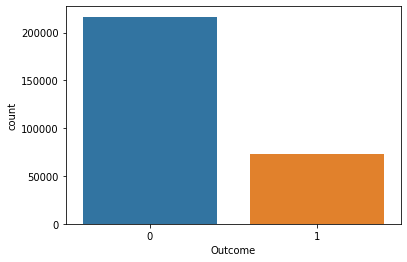

In [45]:
# A bar plot to visualise the imbalance residing in the dataset.
import seaborn as sns
g = sns.countplot(raw_stop_search_2["Outcome"])
plt.show()

In [ ]:
#!pip install -U imbalanced-learn

#####Undersampler (Experimental)

In [ ]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

strat = {1:75000} # TODO Under sample strategy needs numbers
undersampler = RandomUnderSampler(sampling_strategy =strat)
instances_under, targets_under = undersampler.fit_resample(instances, targets)
# g = sns.countplot(targets_under[0])
# plt.show()
print_df_outcome_after = (pd.DataFrame(targets_under,columns=["Outcome"]))
g = sns.countplot(print_df_outcome_after["Outcome"])
print("The number of instances in the dataset: ",len(print_df_outcome_after))
print("Disposal: ", (print_df_outcome_after["Outcome"]==1).sum())
print("Penalty/Caution: ", (print_df_outcome_after["Outcome"]==2).sum())
print("Court Summoning: ", (print_df_outcome_after["Outcome"]==3).sum())
print("Community resolution: ", (print_df_outcome_after["Outcome"]==4).sum())
print("Arrest: ", (print_df_outcome_after["Outcome"]==5).sum())

#####Oversampler (Main)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is depre

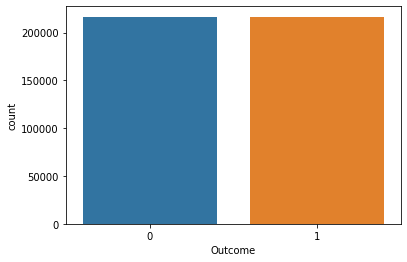

In [46]:
#Oversampling the minority class through random copying in order to make both 
#   classes have a close count leading to balancing the dataset and solving the Accuracy Paradox
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
instances_over, targets_over = oversample.fit_resample(instances, targets)
# Plotting how both classes now have a close count of 220000 solving imbalance
print_df_outcome_after = (pd.DataFrame(targets_over,columns=["Outcome"]))
g = sns.countplot(print_df_outcome_after["Outcome"])

In [47]:
# Assigning the over sampled dataset to replace the old dataset 
x_stop_search_2 = instances_over
y_stop_search_2 = targets_over

In [48]:
#Splitting the dataset into training and testing datasets with a distribution
#   of 70% for training instances and 30% for testing instances
x_train_stop_search_2, x_test_stop_search_2, y_train_stop_search_2, y_test_stop_search_2 = train_test_split(x_stop_search_2,y_stop_search_2,
                                                                                                   test_size=0.3,random_state=50, stratify=y_stop_search_2)

In [49]:
#Showing the lengths of the training and testing subsets (70/30)%
print('Training instances Length: ',len(x_train_stop_search_2),'\nTesting instances Length: ',len(x_test_stop_search_2))
x_train_stop_search_2.shape

Training instances Length:  303258 
Testing instances Length:  129968


(303258, 4)

In [50]:
(targets["Outcome"] == 1).sum()

72492

###Model Creation (Second Preprocessing Approach)

#### Random Forest Classifier with GridSearchCv

In [ ]:
#Running GridSearchCV to determine the most suitable hyperparameters for the RandomForestClassifier
#   
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
random_forest = RandomForestClassifier()
params = {'criterion':['entropy'],'max_depth':range(2,7),'n_estimators':[5,10,25,50,100]}
cross_val = RepeatedStratifiedKFold(n_splits=5,n_repeats=2)
gridSearch_CV = GridSearchCV(random_forest,params,cv=cross_val,return_train_score=False)
gridSearch_CV = gridSearch_CV.fit(x_train_stop_search_2,y_train_stop_search_2.ravel())
gridSearch_CV.best_params_

In [ ]:
gridSearch_CV.best_score_

In [60]:
# Using the parameters provided by the GridSearch Optemizer for the random forest
#   the accuracy as shown below is 56% with a recall demonstrated in the following cell
random_forest = RandomForestClassifier(criterion='entropy',max_depth=3,n_estimators=5)
random_forest.fit(x_train_stop_search_2,y_train_stop_search_2.ravel())

prediction = random_forest.predict(x_test_stop_search_2)
random_forest.score(x_test_stop_search_2,y_test_stop_search_2.ravel())

0.5641554633597073

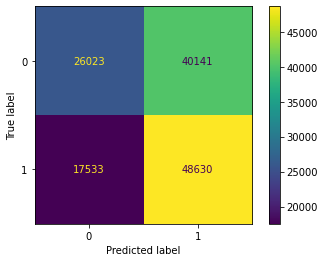

The models precision [0.59746074 0.54781404] and recall [0.39331056 0.73500295] with a fbeta score of [0.4743529  0.62775117]


In [61]:
#showing the confusion matrix of the random forest and the precision and recall
#   which showed to be 57% precision and 56.6% recall and a fbeta score of 56%
#   it can be also seen that the classifier does missclassify 37357 of class 0 to class 1
# & Micclassifies 22032 of class 1 to class 0
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
plot_confusion_matrix(random_forest,x_test_stop_search_2,y_test_stop_search_2,values_format='d')
plt.show()
scores = precision_recall_fscore_support(y_test_stop_search_2, prediction)
print("The models precision {} and recall {} with a fbeta score of {}".format(scores[0],scores[1],scores[2]))

#### Multi-Layer Perceptron MLP classifier

In [ ]:
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier()
parameters = {'activation':['relu','logistic'], 'learning_rate':['constant','adaptive']} #setting the desired parameters space in a dictionary
cross_validation = RepeatedStratifiedKFold(n_splits=10,n_repeats=3)
grid_search = GridSearchCV(classifier,parameters,cv=cross_validation,return_train_score=False) #passing the model and the parameters space to GridSearchCV
grid_search = grid_search.fit(x_train_stop_search_2,y_train_stop_search_2.ravel()) # fitting the model to assess the model's performance using different combinations
grid_search.best_params_ #returns the parameters that allowed the classifier to gain its best results

In [ ]:
grid_search.best_score_

In [62]:
 #Using the Standard MLP classifier to be tested with 
 from sklearn.neural_network import MLPClassifier

 classifier = MLPClassifier( learning_rate='adaptive')
 classifier.fit(x_train_stop_search_2, y_train_stop_search_2)
 classifier.score(x_test_stop_search_2,y_test_stop_search_2)


0.5727855993107982

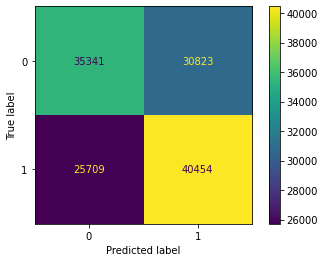

The models precision 0.5732233037830459 and recall 0.5727855993107982 with a fbeta score of 0.5721466971673372


In [63]:
prediction = classifier.predict(x_test_stop_search_2)
plot_confusion_matrix(classifier,x_test_stop_search_2,y_test_stop_search_2,values_format='d')
plt.show()
scores = precision_recall_fscore_support(y_test_stop_search_2, prediction, average = 'weighted', zero_division=1)
print("The models precision {} and recall {} with a fbeta score of {}".format(scores[0],scores[1],scores[2]))

## AI Fairness 360 (AIF360) Debiasing

In [51]:
!pip install aif360

     |████████████████████████████████| 184kB 7.5MB/s 
     |████████████████████████████████| 358kB 11.5MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-cp37-none-any.whl size=30180 sha256=0a40ddfcd9f7be80b0da3ed334d60f1db1cbf99a6a5582c57b1e5f1af52e07b8
  Stored in directory: /root/.cache/pip/wheels/02/e4/0b/aaab481fc5dd2a4ea59e78bc7231bb6aae7635ca7ee79f8ae5
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491636 sha256=7feef6f962162a3c9ebfaa2c99f9dc148c0c98324616fc31adce98e78b62ac20
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built memory-profiler shap


In [52]:
!pip install BlackBoxAuditing

     |████████████████████████████████| 2.6MB 7.4MB/s 
  Created wheel for BlackBoxAuditing: filename=BlackBoxAuditing-0.1.54-py2.py3-none-any.whl size=1394769 sha256=0d94195998d5c0b2855b52e2d8c3b90b1608e23745511d48437e9aa4065d3345
  Stored in directory: /root/.cache/pip/wheels/66/82/7b/ac2a79b8caf97e15ed415162a7f272cbba1e2e2c851fa76ae3
Successfully built BlackBoxAuditing


### Dataset Initialization

In [53]:
import aif360
from aif360.datasets import StandardDataset
from IPython.display import Markdown, display
raw_stop_search_2_aif360 =StandardDataset(raw_stop_search_2, label_name='Outcome',favorable_classes=[0],protected_attribute_names=['Self-defined ethnicity'], privileged_classes=[[1.0]])

In [54]:
def display_info(aif_data):
  display(Markdown("shape"))
  print(aif_data.features.shape)
  display(Markdown("Favorable and unfavorable labels"))
  print(aif_data.favorable_label, aif_data.unfavorable_label)
  display(Markdown("Protected attribute names"))
  print(aif_data.protected_attribute_names)
  display(Markdown("Privileged and unprivileged protected attribute values"))
  print(aif_data.privileged_protected_attributes, aif_data.unprivileged_protected_attributes)
  display(Markdown("Dataset feature names"))
  print(aif_data.feature_names)


**As shown below:**
* The favorable calss is set to be 0 which is disposal
* the protected attribute is set to be the Self-defined ethnicity
* the previliged ethnicity is set to be White with 1.0
* as the AIF360 automatically extracts the outcome therefore the shapes and the dataset feature names contain 4 features each.

In [55]:
display_info(raw_stop_search_2_aif360)

shape

(289105, 4)


Favorable and unfavorable labels

0.0 1.0


Protected attribute names

['Self-defined ethnicity']


Privileged and unprivileged protected attribute values

[array([1.])] [array([2., 3., 4., 5.])]


Dataset feature names

['Gender', 'Age range', 'Self-defined ethnicity', 'Object of search']


In [56]:
training_aif360,testing_aif360 = raw_stop_search_2_aif360.split([0.7], shuffle=False)

In [57]:
display(Markdown("Shape of the training subset"))
print(training_aif360.features.shape)
display(Markdown("Shape of the testing dataset"))
print(testing_aif360.features.shape)

Shape of the training subset

(202373, 4)


Shape of the testing dataset

(86732, 4)


In [58]:
x_train_aif=training_aif360.features
y_train_aif=training_aif360.labels.ravel()

In [104]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
def get_model_performance(X_test, y_true, y_pred, probs):
    accuracy = accuracy_score(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)

    return accuracy, matrix, f1, fpr, tpr, roc_auc

def plot_model_performance(model, X_test, y_true):
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)

    display(Markdown('#### Accuracy of the model :'))
    print(accuracy)
    display(Markdown('#### F1 score of the model :'))
    print(f1)

    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(1, 2, 1)
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')

    ax = fig.add_subplot(1, 2, 2)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")

### Random Forest Classifier Before OverSampling -Benchmark

In [60]:
random_forest_aif360=RandomForestClassifier(criterion='entropy',max_depth=4,n_estimators=20)
random_forest_aif360=random_forest_aif360.fit(x_train_aif,y_train_aif,
                                                                sample_weight=training_aif360.instance_weights)

In [61]:
x_test_aif = testing_aif360.features
y_test_aif = testing_aif360.labels.ravel()

#### Accuracy of the model :

0.7311718858091593


#### F1 score of the model :

0.0


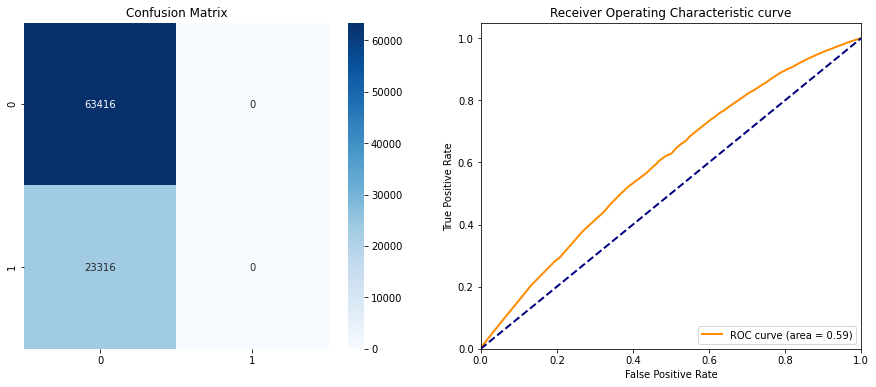

In [62]:
import matplotlib
plot_model_performance(random_forest_aif360, x_test_aif, y_test_aif)

### OverSampling and Resplitting

In [63]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_train_aif, y_train_aif = oversample.fit_resample(raw_stop_search_2_aif360.features,raw_stop_search_2_aif360.labels)
stop_search_aif360_oversampled = pd.DataFrame(data=x_train_aif,columns=['Gender','Age range','Self-defined ethnicity','Object of search'],dtype=int)
y_train_aif=pd.DataFrame(data=y_train_aif,columns=['Outcome'])
outcomes = y_train_aif['Outcome']
stop_search_aif360_oversampled = stop_search_aif360_oversampled.join(outcomes)
stop_search_aif360_oversampled =StandardDataset(stop_search_aif360_oversampled, label_name='Outcome',favorable_classes=[0],protected_attribute_names=['Self-defined ethnicity'], privileged_classes=[[1.0]])
display_info(stop_search_aif360_oversampled)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


shape

(433226, 4)


Favorable and unfavorable labels

0.0 1.0


Protected attribute names

['Self-defined ethnicity']


Privileged and unprivileged protected attribute values

[array([1.])] [array([2., 3., 4., 5.])]


Dataset feature names

['Gender', 'Age range', 'Self-defined ethnicity', 'Object of search']


In [64]:
training_aif360_oversampled,testing_aif360_oversampled = stop_search_aif360_oversampled.split([0.7], shuffle=True)
display(Markdown("Shape of the training subset"))
print(training_aif360_oversampled.features.shape)
display(Markdown("Shape of the testing dataset"))
print(testing_aif360_oversampled.features.shape)

Shape of the training subset

(303258, 4)


Shape of the testing dataset

(129968, 4)


In [65]:
x_train_aif=training_aif360_oversampled.features
y_train_aif=training_aif360_oversampled.labels.ravel()
x_test_aif = testing_aif360_oversampled.features
y_test_aif = testing_aif360_oversampled.labels.ravel()

In [66]:
!pip install fairlearn

     |████████████████████████████████| 24.6MB 129kB/s 


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


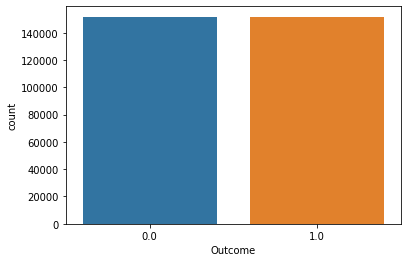

In [67]:

print_df_outcome_after = (pd.DataFrame(y_train_aif,columns=["Outcome"]))
g = sns.countplot(print_df_outcome_after["Outcome"])

#### Plotting and Analysis Functions

Such functions will be utilized further in the code

In [119]:
from aif360.datasets import StandardDataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from aif360.metrics import ClassificationMetric
from aif360.metrics import BinaryLabelDatasetMetric

from aif360.algorithms.preprocessing import LFR, Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
#from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [69]:
def get_fair_metrics_and_plot(data, model, plot=True, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

In [70]:
# A dataframe that logs all the fair metrics for all of the models in the debiasing phase
#   will help in determining the most effective debiasing approach
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

###Models Fairness After OverSampling

####Random Forest Classifier

In [ ]:
random_forest = RandomForestClassifier()
params = {'criterion':['entropy'],'max_depth':[3,8,15],'n_estimators':[5,10,25,50,100]}
cross_val = RepeatedStratifiedKFold(n_splits=5,n_repeats=2)
gridSearch_CV = GridSearchCV(random_forest,params,cv=cross_val,return_train_score=False)
gridSearch_CV = gridSearch_CV.fit(x_train_aif,y_train_aif)
gridSearch_CV.best_params_

In [71]:
random_forest_aif360=RandomForestClassifier(criterion='entropy',max_depth=4,n_estimators=20)
random_forest_aif360=random_forest_aif360.fit(x_train_aif,y_train_aif)

#### Accuracy of the model :

0.5710251754277976


#### F1 score of the model :

0.6157430062098103


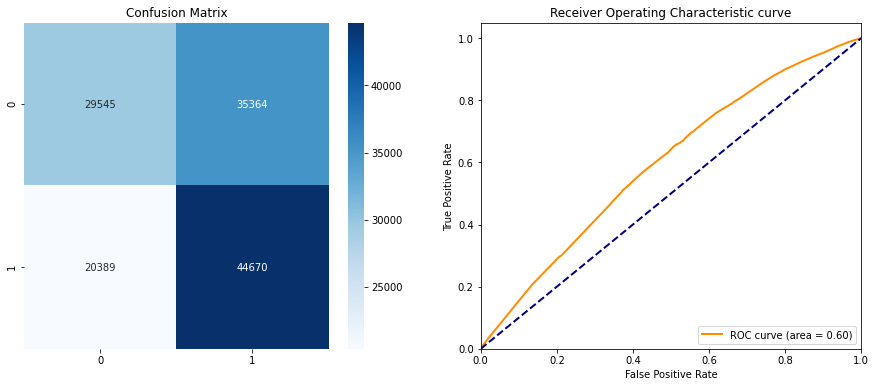

In [72]:
import matplotlib
plot_model_performance(random_forest_aif360, x_test_aif, y_test_aif)

 Bias metrics for the Police Model

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the Self-defined ethnicity attribute :

With default thresholds, bias against unprivileged group detected in **1** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.000000,0.000000,1.00000,0.000000
Self-defined ethnicity,-0.027502,-0.023162,0.027734,0.86099,0.368216


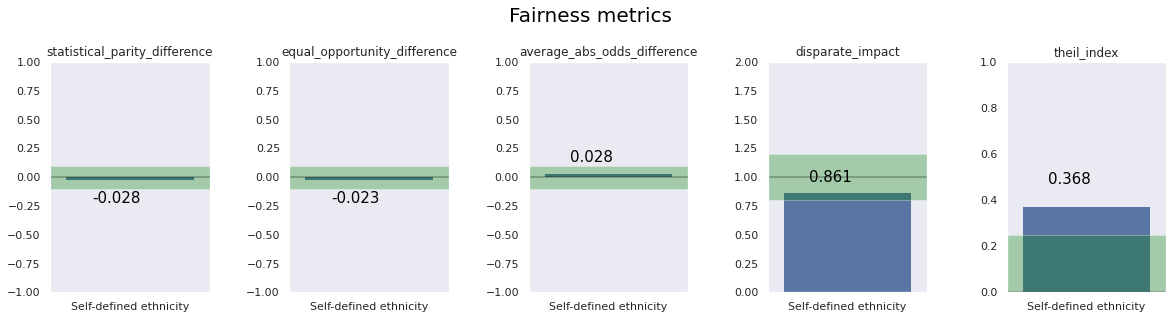

In [73]:
#Showing the fairness of the random forest classifier
display(Markdown(' Bias metrics for the Police Model'))
fair = get_fair_metrics_and_plot(testing_aif360_oversampled, random_forest_aif360)

In [74]:
rf_aif360 = random_forest_aif360
probs = rf_aif360.predict_proba(testing_aif360_oversampled.features)
preds = rf_aif360.predict(testing_aif360_oversampled.features)
algo_metrics = add_to_df_algo_metrics(algo_metrics, rf_aif360, fair, preds, probs, 'RandomForest-Origin')

####Multi-Layer Perceptron MLP

In [75]:
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier(learning_rate='adaptive')
classifier.fit(x_train_aif, y_train_aif)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

#### Accuracy of the model :

0.5767342730518281


#### F1 score of the model :

0.6066400188775036


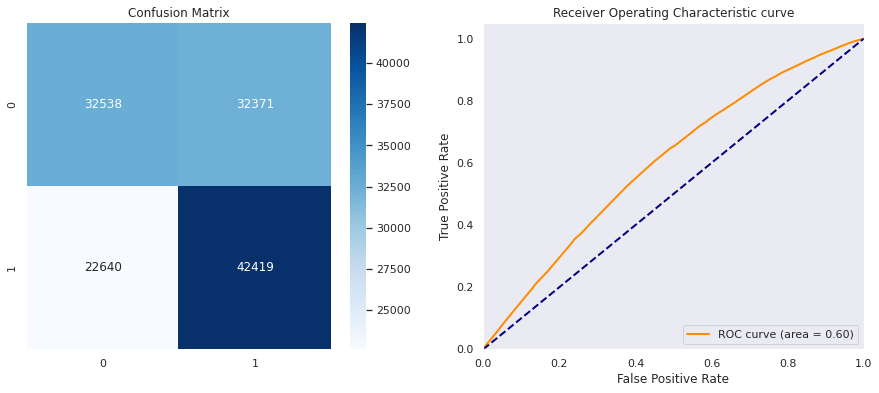

In [76]:
import matplotlib
plot_model_performance(classifier, x_test_aif, y_test_aif)

### Bias metrics for the Sex model

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the Self-defined ethnicity attribute :

With default thresholds, bias against unprivileged group detected in **5** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.000000,0.000000,1.000000,0.000000
Self-defined ethnicity,-0.234431,-0.245578,0.235185,0.454678,0.338855


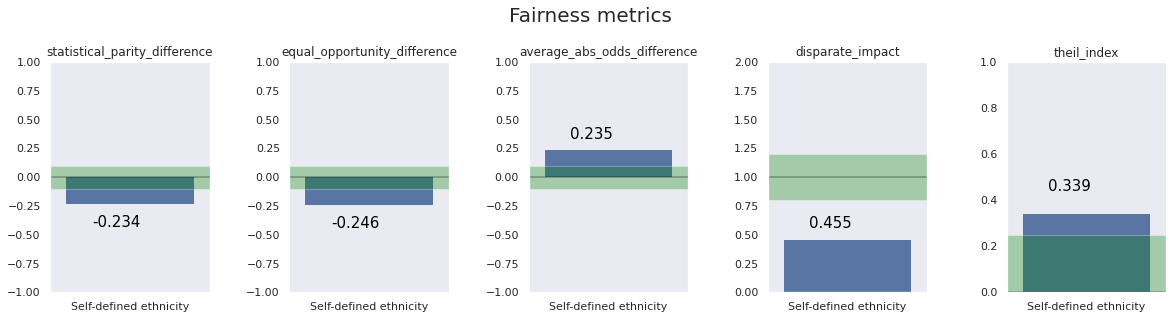

In [77]:
#Shwoing the fairnes metrics for the MLP classifier
display(Markdown('### Bias metrics for the Sex model'))
fair = get_fair_metrics_and_plot(testing_aif360_oversampled, classifier)

In [78]:
probs = classifier.predict_proba(testing_aif360_oversampled.features)
preds = classifier.predict(testing_aif360_oversampled.features)
algo_metrics = add_to_df_algo_metrics(algo_metrics, classifier, fair, preds, probs, 'MLP-Origin')

###AIF360 Debiasing Techniques

#### Disperate Impact Remover

In [122]:
# Using the preprocessing technique (DisparateImpactRemover) that enhances the disparate impact
from aif360.algorithms.preprocessing import DisparateImpactRemover
DIR = DisparateImpactRemover()
training_DIR = DIR.fit_transform(training_aif360_oversampled)
testing_DIR = DIR.fit_transform(testing_aif360_oversampled)

#### Accuracy of the model :

0.5710559522343962


#### F1 score of the model :

0.6150329731036149


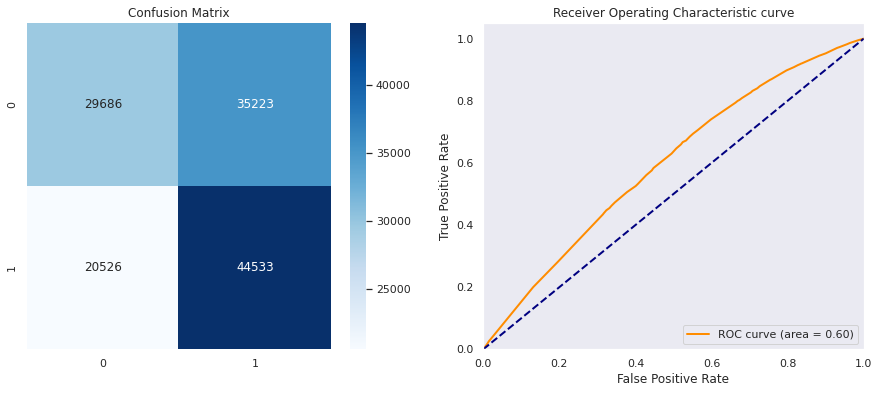

In [123]:
x_train_aif=training_DIR.features
y_train_aif=training_DIR.labels.ravel()
x_test_aif = testing_DIR.features
y_test_aif = testing_DIR.labels.ravel()
rf = RandomForestClassifier(criterion='entropy',max_depth=4,n_estimators=20)
rf.fit(x_train_aif, y_train_aif)
plot_model_performance(rf, x_test_aif, y_test_aif)

### Bias metrics for the Sex model

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the Self-defined ethnicity attribute :

With default thresholds, bias against unprivileged group detected in **1** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.000000,0.000000,1.000000,0.000000
Self-defined ethnicity,-0.026789,-0.022431,0.027022,0.864589,0.366856


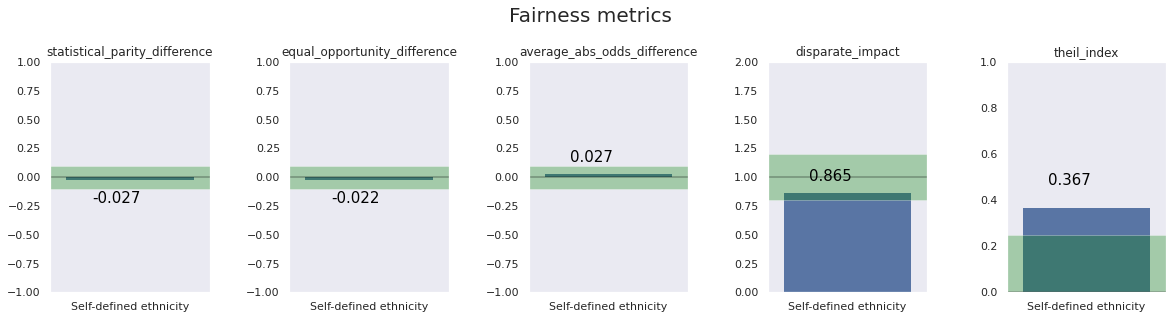

In [124]:
display(Markdown('### Bias metrics for the Sex model'))
fair = get_fair_metrics_and_plot(testing_DIR, rf)

In [82]:
def get_attributes(data, selected_attr=None):
    unprivileged_groups = []
    privileged_groups = []
    if selected_attr == None:
        selected_attr = data.protected_attribute_names
    
    for attr in selected_attr:
            idx = data.protected_attribute_names.index(attr)
            privileged_groups.append({attr:data.privileged_protected_attributes[idx]}) 
            unprivileged_groups.append({attr:data.unprivileged_protected_attributes[idx]}) 

    return privileged_groups, unprivileged_groups

#### Reweighing

In [83]:
from time import time
privileged_groups, unprivileged_groups = get_attributes(training_aif360_oversampled, selected_attr=['Self-defined ethnicity'])
t0 = time()
np.seterr('warn')
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
# RW.fit(data_orig_train)
training_Reweighing = RW.fit_transform(training_aif360_oversampled)

# Train and save the model

random_forest_Reweighing = RandomForestClassifier(criterion='entropy',max_depth=5,n_estimators=20).fit(training_Reweighing.features, 
                     training_Reweighing.labels.ravel(),sample_weight=training_aif360_oversampled.instance_weights)

testing_Reweighing = RW.transform(testing_aif360_oversampled)
fair = get_fair_metrics_and_plot(testing_aif360_oversampled, random_forest_Reweighing, plot=False)
probs = random_forest_Reweighing.predict_proba(testing_aif360_oversampled.features)
preds = random_forest_Reweighing.predict(testing_aif360_oversampled.features)

algo_metrics = add_to_df_algo_metrics(algo_metrics, random_forest_Reweighing, fair, preds, probs, 'Reweighing')
print('time elapsed : %.2fs'%(time()-t0))


invalid value encountered in double_scalars
invalid value encountered in double_scalars


time elapsed : 2.95s


#### Accuracy of the model :

0.5710482580327465


#### F1 score of the model :

0.6227449282031156


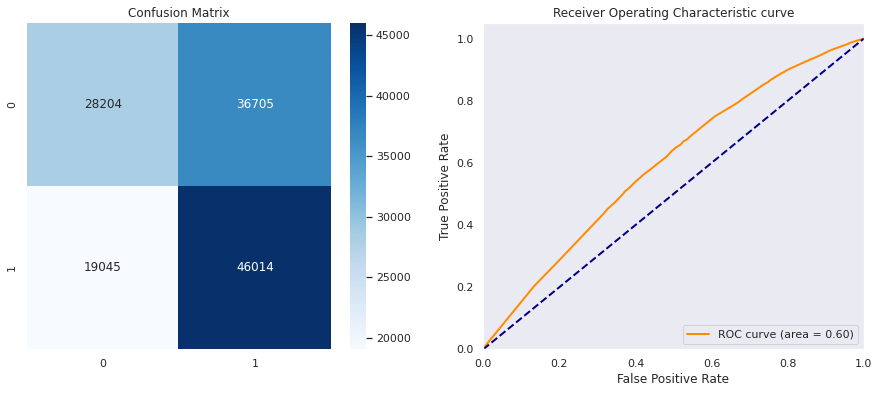

In [84]:
x_train_reweighted = training_Reweighing.features
y_train_reweighted = training_Reweighing.labels.ravel()
x_test_reweighted = testing_Reweighing.features
y_test_reweighted = testing_Reweighing.labels.ravel()
random_forest_Reweighing = RandomForestClassifier(criterion='entropy',max_depth=4,n_estimators=20)
random_forest_Reweighing.fit(x_train_aif, y_train_aif)
plot_model_performance(random_forest_Reweighing, x_test_aif, y_test_aif)


### Bias metrics for the Sex model

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the Self-defined ethnicity attribute :

With default thresholds, bias against unprivileged group detected in **1** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.000000,0.000000,1.000000,0.000000
Self-defined ethnicity,-0.029142,-0.029026,0.028364,0.833292,0.381129


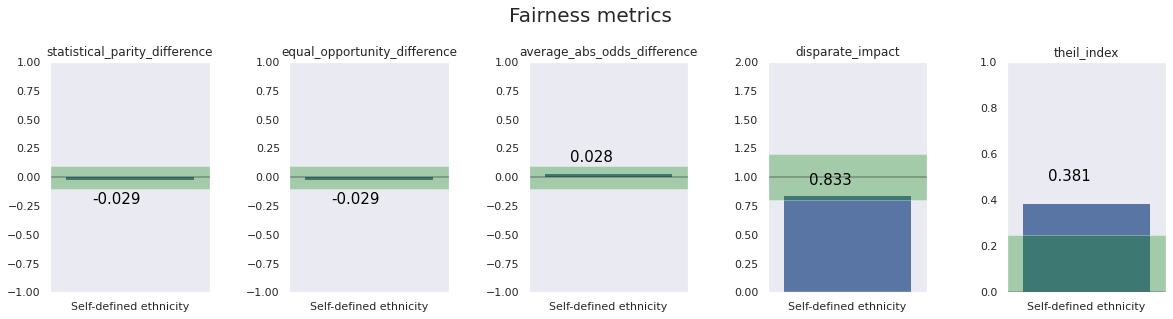

In [85]:
display(Markdown('### Bias metrics for the Sex model'))
fair = get_fair_metrics_and_plot(testing_Reweighing, random_forest_Reweighing)

In [86]:
!pip install tensorflow

#### Learning Fair Representation

In [120]:
#@TODO: Learning the fairness model
privileged_groups, unprivileged_groups = get_attributes(training_aif360_oversampled, selected_attr=['Self-defined ethnicity'])
t0 = time()

LFR_model = LFR(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, k=5, verbose=0)
# LFR.fit(data_orig_train)
data_transf_train = LFR_model.fit_transform(training_aif360_oversampled)
  
# Train and save the model
rf_transf = RandomForestClassifier().fit(data_transf_train.features, 
                     data_transf_train.labels.ravel(), 
                     sample_weight=data_transf_train.instance_weights)

data_transf_test = LFR_model.transform(testing_aif360_oversampled)
fair = get_fair_metrics_and_plot(data_transf_test, rf_transf, plot=False)
probs = rf_transf.predict_proba(testing_aif360_oversampled.features)
preds = rf_transf.predict(testing_aif360_oversampled.features)

algo_metrics = add_to_df_algo_metrics(algo_metrics, rf_transf, fair, preds, probs, 'LFR')
print('time elapsed : %.2fs'%(time()-t0))

invalid value encountered in double_scalars
invalid value encountered in double_scalars


time elapsed : 460.91s


#### Adversarial Debiasing

In [88]:
privileged_groups, unprivileged_groups = get_attributes(training_aif360_oversampled, selected_attr=['Self-defined ethnicity'])
t0 = time()
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from aif360.algorithms.inprocessing import AdversarialDebiasing
# sess.close()
# tf.reset_default_graph()
sess = tf.compat.v1.Session()
#tf.disable_eager_execution()
debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          num_epochs=10,
                          debias=True,sess=sess
                          )
#sess.close()
debiased_model.fit(training_aif360_oversampled)

fair = get_fair_metrics_and_plot(testing_aif360_oversampled, debiased_model, plot=False, model_aif=True)
data_pred = debiased_model.predict(testing_aif360_oversampled)

algo_metrics = add_to_df_algo_metrics(algo_metrics, debiased_model, fair, data_pred.labels, data_pred.scores, 'AdvDebiasing')
print('time elapsed : %.2fs'%(time()-t0))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
epoch 0; iter: 0; batch classifier loss: 0.712970; batch adversarial loss: 0.177035
epoch 0; iter: 200; batch classifier loss: 1.367844; batch adversarial loss: 0.260791
epoch 0; iter: 400; batch classifier loss: 1.274444; batch adversarial loss: -0.162548
epoch 0; iter: 600; batch classifier loss: 1.412205; batch adversarial loss: -0.746525
epoch 0; iter: 800; batch classifier loss: 1.628319; batch adversarial loss: -0.779657
epoch 0; iter: 1000; batch classifier loss: 1.812760; batch adversarial loss: -1.338242
epoch 0; iter: 1200; batch classifier loss: 2.261001; batch adversarial loss: -1.723761
epoch 0; iter: 1400; batch classifier loss: 2.651307; batch adversarial loss: -2.079674
epoch 0; iter: 1600; batch classifier loss: 2.203507; batch adversarial loss: -2.410375
epoch 0; iter: 1800; batch classifier loss: 1.962218; batch adversarial loss: -2.512356
epoch 0; iter:

In [89]:
testing_aif360_oversampled_pred = testing_aif360_oversampled.copy(deepcopy=True)

# Prediction with the original RandomForest model
scores = np.zeros_like(testing_aif360_oversampled.labels)
scores = rf.predict_proba(testing_aif360_oversampled.features)[:,1].reshape(-1,1)
testing_aif360_oversampled_pred.scores = scores

preds = np.zeros_like(testing_aif360_oversampled.labels)
preds = rf.predict(testing_aif360_oversampled.features).reshape(-1,1)
testing_aif360_oversampled_pred.labels = preds

def format_probs(probs1):
    probs1 = np.array(probs1)
    probs0 = np.array(1-probs1)
    return np.concatenate((probs0, probs1), axis=1)

In [90]:
privileged_groups, unprivileged_groups = get_attributes(training_aif360_oversampled, selected_attr=['Self-defined ethnicity'])
t0 = time()

cost_constraint = "fpr" # "fnr", "fpr", "weighted"

CPP = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=42)

CPP = CPP.fit(testing_aif360_oversampled, testing_aif360_oversampled_pred)
transfer_pred = CPP.predict(testing_aif360_oversampled_pred)

fair = fair_metrics(testing_aif360_oversampled, testing_aif360_oversampled_pred, pred_is_dataset=True)

algo_metrics = add_to_df_algo_metrics(algo_metrics, 
                                      CPP, 
                                      fair, 
                                      transfer_pred.labels, 
                                      format_probs(transfer_pred.scores), 
                                      'CalibratedEqOdds')
print('time elapsed : %.2fs'%(time()-t0))

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


time elapsed : 1.66s


In [91]:
[algo_metrics.loc['RandomForest-Origin','fair_metrics']][0].columns.values

array(['statistical_parity_difference', 'equal_opportunity_difference',
       'average_abs_odds_difference', 'disparate_impact', 'theil_index'],
      dtype=object)

In [92]:
def compare_fair_metrics(algo_metrics, attr='Self-defined ethnicity'):
    
    df_metrics = pd.DataFrame(columns=[algo_metrics.loc['RandomForest-Origin','fair_metrics']][0].columns.values)
    for fair in algo_metrics.loc[:,'fair_metrics']:
        df_metrics = df_metrics.append(fair.loc[attr], ignore_index=True)

    df_metrics.index = algo_metrics.index.values
    df_metrics = df_metrics.replace([np.inf, -np.inf], np.NaN)
    
    display(df_metrics)
    plot_fair_metrics_plotly(df_metrics)
    score = score_fair_metrics(df_metrics)
    plot_score_fair_metrics(score.dropna())

In [93]:
def plot_fair_metrics_plotly(fair_metrics):
    bottom = [-1, -1, -1, 0, 0]
    max_valid = [0.1, 0.1, 0.1, 1.2, 0.25]
    min_valid = [-0.1, -0.1, -0.1, 0.8, 0]
    cols = fair_metrics.columns.values

    for i in range(0, 5):
        col = cols[i]

        x, y = (fair_metrics[col].values, fair_metrics.index)
        colors = []
        for v in x:
            color = '#e74c3c' if v < min_valid[i] or v > max_valid[i] else '#2ecc71'
            colors.append(color)

        trace = go.Bar(x=x, y=y, marker=dict(color=colors)
                       , opacity=0.9, orientation='h')

        layout = go.Layout(barmode='group',
                           title=col,
                           xaxis=dict(range=[bottom[i], bottom[i] + 2]),
                           yaxis=go.layout.YAxis(automargin=True),
                           shapes=[
                               {
                                   'type': 'line',
                                   'x0': min_valid[i],
                                   'y0': -1,
                                   'x1': min_valid[i],
                                   'y1': len(y),
                                   'line': {
                                       'color': 'rgb(0, 0, 0)',
                                       'width': 2,
                                   },
                               }, {
                                   'type': 'line',
                                   'x0': max_valid[i],
                                   'y0': -1,
                                   'x1': max_valid[i],
                                   'y1': len(y),
                                   'line': {
                                       'color': 'rgb(0, 0, 0)',
                                       'width': 2,
                                   },
                               }])
        fig = go.Figure([trace], layout=layout)
        py.iplot(fig)


def plot_score_fair_metrics(score):
    display(score.sort_values(['nb_valid', 'score'], ascending=[0, 1]))
    score.sort_values(['nb_valid', 'score'], ascending=[1, 0], inplace=True)

    gold, silver, bronze, other = ('#FFA400', '#bdc3c7', '#cd7f32', '#3498db')
    colors = [gold if i == 0 else silver if i == 1 else bronze if i == 2 else other for i in range(0, len(score))]
    colors = [c for c in reversed(colors)]

    x, y = (score['score'].values, score.index)

    trace = go.Bar(x=x, y=y, marker=dict(color=colors)
                   , opacity=0.9, orientation='h')
    layout = go.Layout(barmode='group',
                       title='Fairest algorithm',
                       yaxis=go.layout.YAxis(automargin=True))
    fig = go.Figure([trace], layout=layout)
    py.iplot(fig)
    

def score_fair_metrics(fair):
    objective = [0, 0, 0, 1, 0]
    max_valid = [0.1, 0.1, 0.1, 1.2, 0.25]
    min_valid = [-0.1, -0.1, -0.1, 0.8, 0]

    nb_valid = np.sum(((fair.values > min_valid) * (fair.values < max_valid)), axis=1)
    score = np.sum(np.abs(fair.values - objective), axis=1)
    score = np.array([score, nb_valid])

    score = pd.DataFrame(data=score.transpose(), columns=['score', 'nb_valid'], index=fair.index)
    return score


def score_all_attr(algo_metrics):
    attributes = algo_metrics.loc['Origin', 'fair_metrics'].index.values[1:]

    all_scores = np.zeros((len(algo_metrics), 2))
    for attr in attributes:
        df_metrics = pd.DataFrame(columns=algo_metrics.loc['RandomForest-Origin', 'fair_metrics'].columns.values)
        for fair in algo_metrics.loc[:, 'fair_metrics']:
            df_metrics = df_metrics.append(fair.loc[attr], ignore_index=True)
        all_scores = all_scores + score_fair_metrics(df_metrics).values

    final = pd.DataFrame(data=all_scores, columns=['score', 'nb_valid'], index=algo_metrics.index)
    return final

In [121]:
compare_fair_metrics(algo_metrics)


,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
RandomForest-Origin,-0.027502,-0.023162,0.027734,0.860990,0.368216
MLP-Origin,-0.234431,-0.245578,0.235185,0.454678,0.338855
Reweighing,-0.027541,-0.023243,0.027775,0.860856,0.366869
LFR,0.000000,0.000000,NaN,1.000000,0.000000
AdvDebiasing,-0.160747,-0.200325,0.161988,0.000000,0.642193
CalibratedEqOdds,-0.026789,-0.022431,0.027022,0.864589,0.366702
LFR,0.000000,0.000000,NaN,1.000000,0.000000
LFR,0.000000,0.000000,NaN,1.000000,0.000000


,score,nb_valid
CalibratedEqOdds,0.578356,4.0
Reweighing,0.584572,4.0
RandomForest-Origin,0.585624,4.0
MLP-Origin,1.599371,0.0
AdvDebiasing,2.165253,0.0



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
